In [95]:
# Import modules and subroutines:

include("../subroutines/Subroutines.jl");

In [16]:
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

cdata_list = ReadIn("../datasets/pyscf_data/h2o_sto-3g_080222%000756.hdf5");
chemical_data = cdata_list[1]
PrintChemData(chemical_data)

Molecule name: h2o
Basis set: sto-3g
Molecular geometry: O 0.0 0.0 0.0; H 1.0 0.0 0.0; H 0.0 1.0 0.0; 
RHF energy: -74.96117113786774
FCI energy: -75.01927599660624


In [17]:
# Run a DMRG calculation (i.e. a single-state subspace):

dmrg1 = GenSubspace(chemical_data, 1, psi_maxdim=7, sweep_num=10, sweep_noise=(1e-6, 1e-7, 1e-8, 0.0));

dmrg1.ord_list = [collect(1:dmrg1.chem_data.N_spt)]

GenStates!(dmrg1, verbose=true);

GenPermOps!(dmrg1)

GenSubspaceMats!(dmrg1, verbose=true)

println("DMRG energy: ", dmrg1.H_mat[1,1] + dmrg1.chem_data.e_nuc)

dens = expect(dmrg1.psi_list[1],"Ntot")
println("Expected particle number: ", dmrg1.chem_data.N_el)
println("Particle number: ", sum(dens))

Generating states:
Progress: [1/1] 
Done!
DMRG energy: -75.01477900894697
Expected particle number: 10
Particle number: 10.000000000000005


In [128]:
bipartitions, entropies = ComputeBipartites(dmrg1, cuts=2000, ns=20)

println(length(bipartitions))

189


In [129]:
dmrg2 = copy(dmrg1);

dmrg2.ord_list = BipartiteAnnealing(
    dmrg2.ord_list, 
    bipartitions, 
    entropies, 
    dmrg2.mparams.psi_maxdim,
    maxiter=50000, 
    swap_mult=2.0, 
    alpha=0.1, 
    stun=true, 
    gamma=5.0, 
    zeta=0.01,
    verbose=true
);

println("\n$(dmrg2.ord_list[1])")

1.000074121920692     
[7, 3, 6, 4, 2, 5, 1]


In [130]:
GenStates!(dmrg2, verbose=true);

GenPermOps!(dmrg2)

GenSubspaceMats!(dmrg2, verbose=true)

println("DMRG energy: ", dmrg2.H_mat[1,1] + dmrg2.chem_data.e_nuc)

dens = expect(dmrg2.psi_list[1],"Ntot")
println("Expected particle number: ", dmrg2.chem_data.N_el)
println("Particle number: ", sum(dens))

Generating states:
Progress: [1/1] 
Done!
DMRG energy: -75.01887487827217
Expected particle number: 10
Particle number: 10.0


In [215]:
tnqe2 = GenSubspace(chemical_data, 13, psi_maxdim=3, sweep_num=6, sweep_noise=(1e-6));

tnqe2.ord_list = [randperm(tnqe2.chem_data.N_spt) for j=1:tnqe2.mparams.M]

tnqe2.ord_list = BipartiteAnnealing(
    tnqe2.ord_list, 
    bipartitions, 
    entropies, 
    tnqe2.mparams.psi_maxdim,
    maxiter=4000, 
    swap_mult=1.0, 
    alpha=1e-6, 
    stun=true, 
    gamma=1e4, 
    zeta=0.015,
    verbose=true
);
println("1/2")
tnqe2.ord_list = BipartiteAnnealing(
    tnqe2.ord_list, 
    bipartitions, 
    entropies, 
    tnqe2.mparams.psi_maxdim,
    maxiter=4000, 
    swap_mult=1.0, 
    alpha=5e-5, 
    stun=true, 
    gamma=5e3, 
    zeta=0.015,
    verbose=true
);

1/2083607941027591    


In [216]:
GenPermOps!(tnqe2, verbose=true)

Generating permutation operators:
Progress: [78/78] 
Done!



Generating states:
Progress: [13/13] 
Done!
Minimum eigenvalue: -83.84629911562337
Condition number: 44280.4335816357
FCI energy: -75.01927599660624
Final energy estimate: -75.00527894661245
Best single ref. estimate: -74.99915085084169
Error: 0.013997049993790256
BSRfE: 0.0201251457645526
Improvement: 0.006128095770762343
Percentage error reduction: 30.44994477285256
Eigenvalue condition numbers: [0.0119, 0.012, 0.012, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0121, 0.0122, 0.0122, 0.0122, 0.0123]
Percent correlation energy with single-geometry DMRG: 65.36409140047208
Percent correlation energy with multi-geometry TNQE: 75.91070644060403


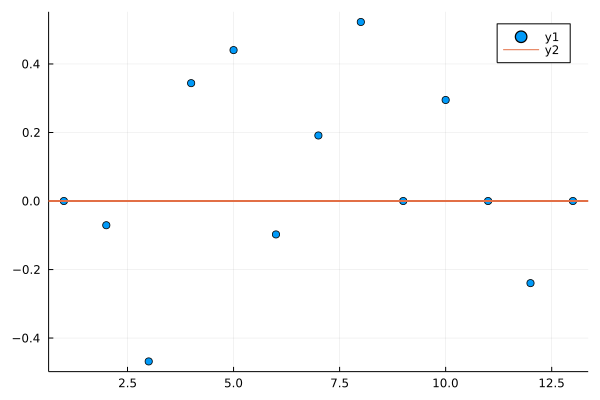

In [217]:
GenStates!(tnqe2, verbose=true);

GenSubspaceMats!(tnqe2, verbose=true)

SolveGenEig!(tnqe2, thresh="inversion", verbose=true)

Minimum eigenvalue: -83.86001676887713.86001676887717; kappa = 194.8477192520071              
Condition number: 194.84771925200815
FCI energy: -75.01927599660624
Final energy estimate: -75.01899659986618
Best single ref. estimate: -74.96882076314786
Error: 0.0002793967400549491
BSRfE: 0.05045523345837921
Improvement: 0.05017583671832426
Percentage error reduction: 99.44624824640754
Eigenvalue condition numbers: [0.0119, 0.012, 0.0121, 0.0121, 0.0121, 0.0121, 0.0122, 0.0122, 0.0122, 0.0122, 0.0122, 0.0124, 0.0161]
Percent correlation energy with single-geometry DMRG: 13.165207602603662
Percent correlation energy with multi-geometry TNQE: 99.51915081437105


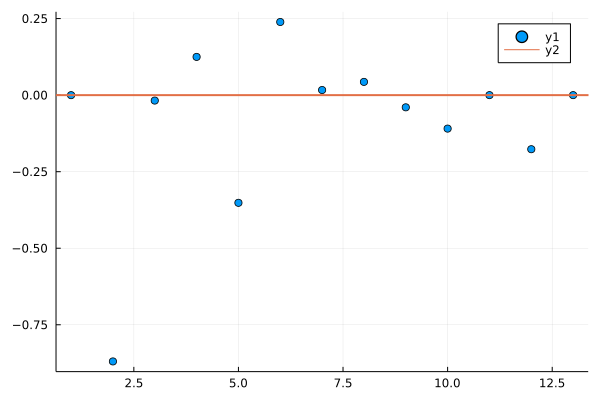

In [219]:
tnqe3 = copy(tnqe2)

MultiGeomOptim!(
    tnqe3, 
    sweeps=6, 
    maxiter=20000, 
    method="bboptim",
    delta=1e-4,
    alpha=2e0,
    stun=true,
    gamma=1e8,
    noise=[1e-3,1e-4,1e-5,1e-6,1e-7, 0.0],
    verbose=true
)

GenSubspaceMats!(tnqe3, verbose=true)

SolveGenEig!(tnqe3, thresh="inversion", verbose=true)